# Movie Recommendation System
### Stvaranje prediktivnog modela preporuke filma pomoću MovieLens dataseta.

Cilj je eksploratorna analiza te razvijanje prediktivnog modela preporuke filma algoritmima strojnog učenja pomoću MovieLens dataseta.
Model bi preporučivao nove filmove korisniku s obzirom na podatke koje ima o korisniku
kao što su koje žanrove preferira, koje filmove je dobro ocijenio te koje loše  te s obzirom na
podatke vrlo sličnih korisnika.

[MovieLens dataset](https://grouplens.org/datasets/movielens/)

U demonstraciji koristimo minimalnu verziju dataseta "ml-latest-small"

## Analiza podataka

In [1]:
#Import paketa

from math import sqrt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Više izlaznih linija
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Svaki film sadrži svoj ID "_movieId_", naslov "_title_" i kategorije žanrova kojima pripada "_genres_".

In [2]:
#Učitana csv file vezan za informacije o filmovima
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Broj filmova u datasetu.

In [3]:
movies['movieId'].count()


9742

Podaci o ocjenjivanju sadrže ID korisnika "_userId_" koji je pogledao film "_movieId_" i ocijenio ga s
ocjenom prikazanom u "_rating_".


In [4]:
#Učitan csv file vezan za ocijenjivanje filmova
ratings = pd.read_csv('ml-latest-small/ratings.csv',usecols=['userId','movieId','rating'])
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


Statistika o ocjenama filmova.

In [5]:
ratings['rating'].describe(include='all')


count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Histogram ocjena i njihovog broja u datasetu.

rating
0.5    1066
1.0    1726
1.5    1386
2.0    3339
2.5    2925
3.0    4986
3.5    4216
4.0    5109
4.5    2710
5.0    2954
Name: movieId, dtype: int64

array([[<AxesSubplot:title={'center':'rating'}>]], dtype=object)

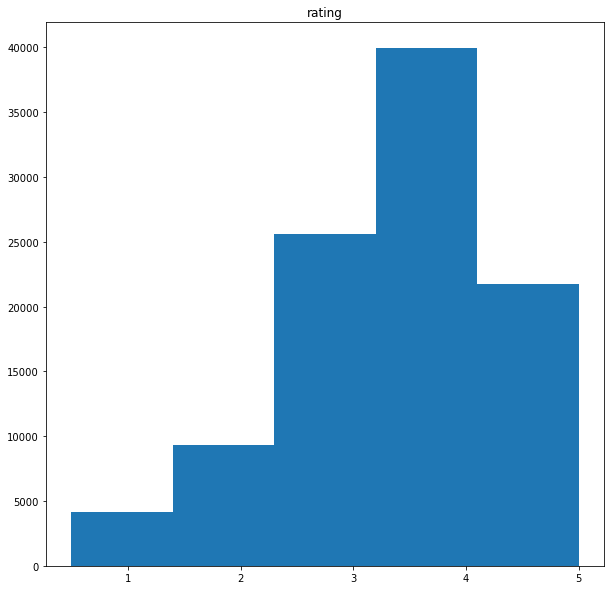

In [6]:
ratings.groupby('rating')['movieId'].nunique()

ratings.hist(column='rating',figsize=(10,10),bins=5,grid=False)

Izbacivanje filmova bez žanra i ispis broja filmova po žanru.

In [7]:
genre_filter = (movies['genres'] == '(no genres listed)')

movies_filtre = movies[~genre_filter]
movies_filtre=movies_filtre.reset_index(drop=True)

genres_count = {}
for row in range(movies_filtre['movieId'].count()):
    for genre in movies_filtre['genres'][row].split("|"):
        if genre!='':
            genres_count[genre]=genres_count.get(genre,0)+1

genres_count

{'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Fantasy': 779,
 'Romance': 1596,
 'Drama': 4361,
 'Action': 1828,
 'Crime': 1199,
 'Thriller': 1894,
 'Horror': 978,
 'Mystery': 573,
 'Sci-Fi': 980,
 'War': 382,
 'Musical': 334,
 'Documentary': 440,
 'IMAX': 158,
 'Western': 167,
 'Film-Noir': 87}

Histogram žanr koji predstavlja broj filmova u pojedinom žanru.

<BarContainer object of 19 artists>

([<matplotlib.axis.YTick at 0x13f35fa3280>,
 [Text(0, 0, 'Adventure'),
  Text(0, 1, 'Animation'),
  Text(0, 2, 'Children'),
  Text(0, 3, 'Comedy'),
  Text(0, 4, 'Fantasy'),
  Text(0, 5, 'Romance'),
  Text(0, 6, 'Drama'),
  Text(0, 7, 'Action'),
  Text(0, 8, 'Crime'),
  Text(0, 9, 'Thriller'),
  Text(0, 10, 'Horror'),
  Text(0, 11, 'Mystery'),
  Text(0, 12, 'Sci-Fi'),
  Text(0, 13, 'War'),
  Text(0, 14, 'Musical'),
  Text(0, 15, 'Documentary'),
  Text(0, 16, 'IMAX'),
  Text(0, 17, 'Western'),
  Text(0, 18, 'Film-Noir')])

Text(0.5, 0, 'Broj Filmova')

Text(0.5, 1.0, 'Popularnost žanrova')

Text(1283, 0.1, '1263')

Text(631, 1.1, '611')

Text(684, 2.1, '664')

Text(3776, 3.1, '3756')

Text(799, 4.1, '779')

Text(1616, 5.1, '1596')

Text(4381, 6.1, '4361')

Text(1848, 7.1, '1828')

Text(1219, 8.1, '1199')

Text(1914, 9.1, '1894')

Text(998, 10.1, '978')

Text(593, 11.1, '573')

Text(1000, 12.1, '980')

Text(402, 13.1, '382')

Text(354, 14.1, '334')

Text(460, 15.1, '440')

Text(178, 16.1, '158')

Text(187, 17.1, '167')

Text(107, 18.1, '87')

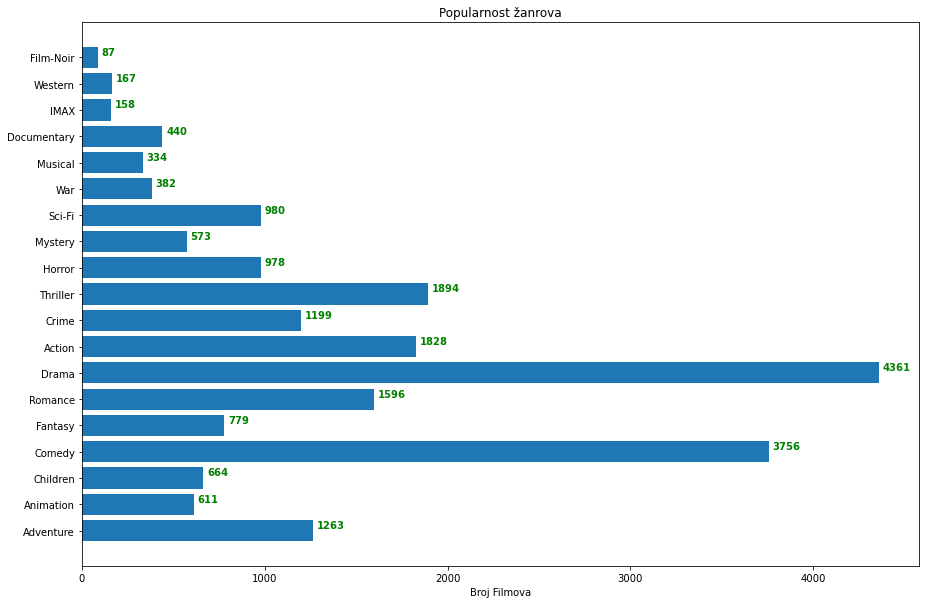

In [8]:
fig, ax = plt.subplots(figsize=(15,10))
ax.barh(range(len(genres_count)),genres_count.values())
plt.yticks(range(len(genres_count)),list(genres_count.keys()))
plt.xlabel('Broj Filmova')
plt.title("Popularnost žanrova")
for i, v in enumerate(genres_count.values()):
    ax.text(v + 20, i + .10, v, color='green', fontweight='bold')


## Razvoj predikativnog modela preporuke filmova

#### 1) _Najgledaniji filmovi_
Početna ideja je predlagati korisnicima filmove
koji su najviše puta  pregledani.

Kako bi dobili te podatke tablice "_movies_" i "_ratings_" se spajaju s obzirom na
atribut "_movieId_", koji se nalazi u obe tablice, u jednu talicu imena **movies_rating**.
Dobivena tablica je grupirana po naslovu filma i izračunat je broj ponavljanja naslova
što predstavlja broj pregleda filma i uzeto je 15 najgledanijih filova kao prijedlog za gledanje.

In [9]:
movies_rating = pd.merge(ratings, movies, on=['movieId'])

movies_rating.groupby('title').size().sort_values(ascending=False)[:15]

title
Forrest Gump (1994)                                      329
Shawshank Redemption, The (1994)                         317
Pulp Fiction (1994)                                      307
Silence of the Lambs, The (1991)                         279
Matrix, The (1999)                                       278
Star Wars: Episode IV - A New Hope (1977)                251
Jurassic Park (1993)                                     238
Braveheart (1995)                                        237
Terminator 2: Judgment Day (1991)                        224
Schindler's List (1993)                                  220
Fight Club (1999)                                        218
Toy Story (1995)                                         215
Star Wars: Episode V - The Empire Strikes Back (1980)    211
Usual Suspects, The (1995)                               204
American Beauty (1999)                                   204
dtype: int64

Problem ovog pristupa je što najviše pogledani filmovi ne
garantiraju da su i najbolje ocjenjeni.

#### 2) _Najbolje ocjenjeni_
Novi prijedlog je predložiti filmove s najboljom ocjenom.
Tablica **movies_rating** se grupira po naslovu filma i računa se prosječna ocjena.
Kao prijedlog uzimaju se filmovi s najvećom ocjenom.

In [10]:
movies_rating.groupby('title')['rating'].mean().sort_values(ascending=False)[:15]



title
Karlson Returns (1970)                           5.0
Winter in Prostokvashino (1984)                  5.0
My Love (2006)                                   5.0
Sorority House Massacre II (1990)                5.0
Winnie the Pooh and the Day of Concern (1972)    5.0
Sorority House Massacre (1986)                   5.0
Bill Hicks: Revelations (1993)                   5.0
My Man Godfrey (1957)                            5.0
Hellbenders (2012)                               5.0
In the blue sea, in the white foam. (1984)       5.0
Won't You Be My Neighbor? (2018)                 5.0
Red Sorghum (Hong gao liang) (1987)              5.0
Love Exposure (Ai No Mukidashi) (2008)           5.0
My Sassy Girl (Yeopgijeogin geunyeo) (2001)      5.0
The Love Bug (1997)                              5.0
Name: rating, dtype: float64

Novi problem predstavljaju filmovi koji su pogledani od strane jednog ili
malog broja korisnika, a ocijenjeni su visokom ocjenom jer se jednako
tretiraju kao i oni koje je veliki broj korisnika visoko ocijenio.

#### 3) _Najbolje ocjenjeni s velikom gledanošću_

Nova ideja je predlagati filmove s viskom ocjenom koji su pogledani i
dobro ocijenjeni od većeg broja korisnika.


Izračun srednje ocjene filma iz svih njegovih ocjena i zbrajanje koliko je puta ocjenjen.
Ta dva podataka dodajemo u dataset filma.

In [11]:
movies_rating = movies_rating.groupby(['movieId','title','genres']) \
       .agg(ratingCount=('userId', 'size'), avgRating=('rating', 'mean')) \
       .reset_index()
movies_rating.head()

,movieId,title,genres,ratingCount,avgRating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215,3.920930
1,2,Jumanji (1995),Adventure|Children|Fantasy,110,3.431818
2,3,Grumpier Old Men (1995),Comedy|Romance,52,3.259615
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,7,2.357143
4,5,Father of the Bride Part II (1995),Comedy,49,3.071429


Ograničimo li se na filmove koji su pogledani barem 100 puta i sortiramo ih po ocjeni
dobijemo sljedeće filmove.

In [12]:
movies_rating_100 = movies_rating.loc[(movies_rating['ratingCount'] >= 100)]
movies_rating_100=movies_rating_100.sort_values(by=['avgRating', 'ratingCount'] ,ascending=False)
movies_rating_100.head(15)

,movieId,title,genres,ratingCount,avgRating
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,317,4.429022
659,858,"Godfather, The (1972)",Crime|Drama,192,4.289062
2224,2959,Fight Club (1999),Action|Crime|Drama|Thriller,218,4.272936
921,1221,"Godfather: Part II, The (1974)",Crime|Drama,129,4.259690
6298,48516,"Departed, The (2006)",Crime|Drama|Thriller,107,4.252336
913,1213,Goodfellas (1990),Crime|Drama,126,4.250000
694,912,Casablanca (1942),Drama|Romance,100,4.240000
6693,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,149,4.238255
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,204,4.237745
898,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,142,4.232394


Popis prvih petnaest filmova u tablici je:

In [13]:
movies_rating_100['title'].head(15)


277                      Shawshank Redemption, The (1994)
659                                 Godfather, The (1972)
2224                                    Fight Club (1999)
921                        Godfather: Part II, The (1974)
6298                                 Departed, The (2006)
913                                     Goodfellas (1990)
694                                     Casablanca (1942)
6693                              Dark Knight, The (2008)
46                             Usual Suspects, The (1995)
898                            Princess Bride, The (1987)
224             Star Wars: Episode IV - A New Hope (1977)
461                               Schindler's List (1993)
908                                 Apocalypse Now (1979)
1733                            American History X (1998)
897     Star Wars: Episode V - The Empire Strikes Back...
Name: title, dtype: object

#### 4) _Težinski prosjek ocjene_


Preporuka filmova pomoću liste najpopularnijih svim korisnicima preporuča iste filmove poredane po izračunatom ratingu
**IMDb-formule**

\begin{equation}
\text TežinskiRating (\bf WR) = \left({{\bf v} \over {\bf v} + {\bf m}} \cdot R\right) + \left({{\bf m} \over {\bf v} + {\bf m}} \cdot C\right)
\end{equation}

gdje je:

v = broj ocjena filma ,

m = minimalni broj ocjena da bi se prikazao u listi (*izračunat kao 90% kvantil*),

R = prosjecna ocjena filma,

C = prosječna ocjena svih filmova.




Računanje srednje ocjene svih filmova i računanje granice 90% kvantila kao donje granice top filmova.

In [14]:
mean_rating = ratings['rating'].mean()
print(mean_rating)

low_vote_number = movies_rating['ratingCount'].quantile(0.90)
print(low_vote_number)

3.501556983616962
27.0


Filtiriraje filmova koji su u top 10% po broju ocjena i njihovo pohranjivanje u novi dataset kvalificiranih filmova.

In [15]:
q_movies = movies_rating.copy().loc[movies_rating['ratingCount']>=low_vote_number]
q_movies.shape

movies_rating.shape

(976, 5)

(9724, 5)

Fukncija za računanje težinskog rating pomoću **IMDb-formule**
Upis u dataset kvalificiranih filmova njihov težinski rating.

In [16]:
def weighed_rating(x, m=low_vote_number, C=mean_rating):
    v = x['ratingCount']
    R = x['avgRating']

    return (v/(v+m) * R) + (m/(m+v) * C)

q_movies['score'] = q_movies.apply(weighed_rating,axis=1)

Sortiranje filmova po izračunatom ratingu i ispis top 15 i najgorih 10.

In [17]:
q_movies = q_movies.sort_values(by='score',ascending=False)

q_movies[['title', 'avgRating', 'ratingCount', 'score']].head(15)
q_movies[['title', 'avgRating', 'ratingCount', 'score']].tail(10)






,title,avgRating,ratingCount,score
277,"Shawshank Redemption, The (1994)",4.429022,317,4.356227
659,"Godfather, The (1972)",4.289062,192,4.191973
2224,Fight Club (1999),4.272936,218,4.187927
224,Star Wars: Episode IV - A New Hope (1977),4.231076,251,4.160223
46,"Usual Suspects, The (1995)",4.237745,204,4.151697
461,Schindler's List (1993),4.225000,220,4.145919
257,Pulp Fiction (1994),4.197068,307,4.140844
897,Star Wars: Episode V - The Empire Strikes Back...,4.215640,211,4.134630
1938,"Matrix, The (1999)",4.192446,278,4.131285
921,"Godfather: Part II, The (1974)",4.259690,129,4.128475


,title,avgRating,ratingCount,score
396,Free Willy (1993),2.391892,37,2.860032
607,Striptease (1996),2.414634,41,2.846206
313,"Flintstones, The (1994)",2.357143,42,2.804957
2856,Hollow Man (2000),2.294872,39,2.788516
1234,I Know What You Did Last Summer (1997),2.109375,32,2.746475
379,Coneheads (1993),2.420635,63,2.744912
1173,Batman & Robin (1997),2.214286,42,2.718001
1144,Anaconda (1997),1.925926,27,2.713741
1372,Godzilla (1998),1.954545,33,2.650701
2028,Wild Wild West (1999),2.207547,53,2.644275


Prethodni pristupi svim korisnicima preporučuju iste filmove i ne uzimaju u obzir da
korisnici imaju različite preference i različito ocjenjuju filmove.


#### 4) Content based preporučvanje

Content based algoritam pomoću sličnosti između filmova traži filmove s sličnim atributima i te preporuča korisniku.

Algoritam se temelji na vađenju svih korisnih informacija o filmu koje sam sadrži i koje su
mu korisnici pridjelili.
Nakon što se prikupe sve informacije, za oređenog korisnika odabere se već pogledani film
i na osnovu njegove sličnosti u prikupljenim informacijama
pokušava se pronaći sličan film i preporučuje se korisniku.



Atributi koje ovdje koristimo su žanrovi iz movies.csv i svi tagovi koje su korisnici upisali u tags.csv za film.
Što je više atributa dostupno za svaki film ovaj će algoritam bolje raditi i pravilnije preproručavati filmove.

Kako bi odredili težinu (_važnost_) atributa koristimo **TF-IDF** score (*term frequency-inverted document frequency score*).

\begin{equation}
\text tfidf_{i,j} = tf_{i,j} \cdot \log (\frac{N}{df_i})
\end{equation}

gdje:
Kada smo izračunali TF-IDF gradimo **Vector Space Model** uz **Cosine similarity**.

Rezultat nam je kvadratna matrica veličine broja filmova gdje na svakom sjecištu leži ocjena njihove sličnosti.


Pri analizi korišten je **ml-lates** dataset koji dodatno sadrži _tag_-ove o filmovima.

In [18]:
moviesLates = pd.read_csv('ml-latest/movies.csv')
moviesLates.head()

ratingsLates = pd.read_csv('ml-latest/ratings.csv',usecols=['userId','movieId','rating'])
ratingsLates.head()

tagsLates = pd.read_csv('ml-latest/tags.csv',usecols=['movieId','tag'])
tagsLates.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


,movieId,tag
0,110,epic
1,110,Medieval
2,260,sci-fi
3,260,space action
4,318,imdb top 250


Čisti se tag dataset tako da se pretvori sve u mala slova i spoje se riječi s razmacima iz jednog taga.
Spajanjem svih tagove jednoga filma od različitih korisnika u dataset movieLates dodaje se
novi atribut tag koji sadrži sve riječi u jednoj konkatenaciji.

In [19]:
tagsLates['tag'] = tagsLates['tag'].apply(lambda x: str(x).replace(" ","").lower())

moviestagsLates = pd.merge(tagsLates.groupby(['movieId'], as_index=False)['tag'].apply(lambda x: " ".join(x)), movies,how='right',on='movieId')

moviestagsLates['tag']=moviestagsLates['tag'].fillna('')

Sada svaki film sadrži tagove od strane različitih korisnika.

In [20]:
moviestagsLates.head()

,movieId,tag,title,genres
0,1,animated buddymovie cartoon cgi comedy compute...,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,fantasy adaptedfrom:book animals badcgi basedo...,Jumanji (1995),Adventure|Children|Fantasy
2,3,moldy old annmargaret burgessmeredith darylhan...,Grumpier Old Men (1995),Comedy|Romance
3,4,characters girlmovie characters chickflick bas...,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,stevemartin stevemartin pregnancy remake aging...,Father of the Bride Part II (1995),Comedy


Funkcija **createSoup** izbacuje sve duplikate tagova iz jednoga filma i ubacuje imena žanrova te
stvara novi stupac u movie datasetu, _soup_ koji sadži sve te ključne riječi.

In [21]:
def createSoup(x):
    infoSet = set(x['tag'].split(' '))

    data = ' '.join(infoSet)

    for genre in x['genres'].split('|'):
        data+=(' ' + genre.lower())
    return data

Nakon poziva funkcije  **createSoup** moviestagsLates izgleda :

In [22]:
moviestagsLates['soup'] = moviestagsLates.apply(createSoup,axis=1)
moviestagsLates.head()

,movieId,tag,title,genres,soup
0,1,animated buddymovie cartoon cgi comedy compute...,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,55movieseverykidshouldsee--entertainmentweekly...
1,2,fantasy adaptedfrom:book animals badcgi basedo...,Jumanji (1995),Adventure|Children|Fantasy,herdsofcgianimals childish forchildren comedy ...
2,3,moldy old annmargaret burgessmeredith darylhan...,Grumpier Old Men (1995),Comedy|Romance,comedy comedinhadevelhinhosengraãƒâ§ada grunru...
3,4,characters girlmovie characters chickflick bas...,Waiting to Exhale (1995),Comedy|Drama|Romance,girlmovie singlemother interracialrelationship...
4,5,stevemartin stevemartin pregnancy remake aging...,Father of the Bride Part II (1995),Comedy,comedy childhoodclassics worstmoviesever daugh...





Stvara se TF-IDF Vectorizer i šalju mu se sve ključne riječi svih filmova.
Stvara se matrica u kojoj redci predstavljaju filmove te se za strupce
još dodaju sve ključne riječi koji sadržavaju IDF vrijednosti o ključnoj riječi.

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')

moviestagsLates['soup'] = moviestagsLates['soup'].fillna('')

tfidf_matrix = tfidf.fit_transform(moviestagsLates['soup'])

tfidf_matrix.shape

tfidf.get_feature_names()[1000:1020]

(9742, 47413)

['ageism',
 'ageissues',
 'agency',
 'agenda',
 'agenoreincrocci',
 'agent',
 'agentcarter',
 'agentcoulson',
 'agentlehandrefriedfor',
 'agentmariahill',
 'agentorange',
 'agentross',
 'agents',
 'agentsmith',
 'agentyellow',
 'ageofsail',
 'agephilosophy',
 'ages',
 'aggression',
 'aggressive']

Stvaranje linear_kernel objekta koji ce pomoću cosine similarity ocjene moći ocjenjivati filmove.
Redak _tfidf_ __matrix_ koji predstavlja vektor pojedinog filma množi se sa svim vektorima filmova
i dobiva se matrica koja za svaki film sadrži informaiju koliko je on sličan u odnosu na drugi film.

In [24]:
from sklearn.metrics.pairwise import linear_kernel

cosin_sin = linear_kernel(tfidf_matrix,tfidf_matrix)

cosin_sin.shape

cosin_sin[1]


(9742, 9742)

array([0.07454594, 1.        , 0.00850871, ..., 0.        , 0.        ,
       0.03778883])

In [25]:
indices = pd.Series(movies.index, index = moviestagsLates['movieId']).drop_duplicates()

indices[:10]

movieId
1     0
2     1
3     2
4     3
5     4
6     5
7     6
8     7
9     8
10    9
dtype: int64

Funkcija koja za dan id filma pomoću sličnosti s drugim filmovima ispisuje slične filmove.

Funkcija prolazi kroz svoj vektor i za svaki drugi film gleda sličnost. Najsličnije filmove
stavlja u listu i korisniku vraća najsličnijih n.

In [26]:
def get_recommendations_by_id(movieId,n=15, cosine_sim=cosin_sin):

    idx = indices[movieId]

    sim_scores = list(enumerate(cosine_sim[idx]))

    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:n+1]

    movie_indices = [i[0] for i in sim_scores]

    return moviestagsLates['movieId'].iloc[movie_indices]

Poziv funkcije za korisnika s ID-om 1 vraća njegovih 15 najsličnijih.

In [27]:
moviestagsLates.loc[moviestagsLates['movieId'].isin(get_recommendations_by_id(1))]

,movieId,tag,title,genres,soup
512,595,disney kids redemption animation disney fairyt...,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX,fathersanddaughters 55movieseverykidshouldsee-...
513,596,characters classic cute fun animation cartoon ...,Pinocchio (1940),Animation|Children|Fantasy|Musical,sneezing christianrub reviewed 2danimation dis...
1757,2355,animation disney pixar insects kevinspacey opp...,"Bug's Life, A (1998)",Adventure|Animation|Children|Comedy,insects acting ants disney comedy animation vo...
2355,3114,pixar sequelbetterthanoriginal abandonment ani...,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,johncusack childish tomhanks daringrescues aba...
3568,4886,funny pixar comedy funny pixar animated animat...,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,missing/kidnappedchild disney hijinks cheating...
3704,5109,disney animation peterpan avi disneyanimatedfe...,Return to Never Land (2002),Adventure|Animation|Children,disneyanimatedfeature disney animation peterpa...
4360,6377,pixar funny pixar family father-sonrelationshi...,Finding Nemo (2003),Adventure|Animation|Children|Comedy,feelgoodmovie missing/kidnappedchild myfav dis...
5374,8961,funny stylized super-hero animation powers ani...,"Incredibles, The (2004)",Action|Adventure|Animation|Children|Comedy,55movieseverykidshouldsee--entertainmentweekly...
6212,45517,redemption villainnonexistentornotneededforgoo...,Cars (2006),Animation|Children|Comedy,losangeles emotionalfiretruck script comedy po...
7355,78499,boring overrated story pixar children adventur...,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX,toplist10 toy dolls timallen violence donrickl...


Funkcija koja za dani id usera računa filmove koje bi se tom useru svidjeli.

Funkcija prolazi kroz sve filmove koje je korisnik pogledao i ocijenio te za svaki od tih
filmova trži njemu najsličnije i množi ih s ocjenom korisnika. Te najsličnije filmove i
njihove ocjene sortira i vraća one koje bi preporučio korisniku.

In [28]:
def get_recommendations_by_user(userId, n = 15, cosine_sim = cosin_sin):
    userMovies = ratingsLates.loc[ratingsLates['userId']==userId]
    watched = pd.Series(userMovies['movieId']).tolist()

    scores=list()

    for item in userMovies.itertuples():
        movieId = item[2]
        rating = item[3]

        idx = indices[movieId]
        sim_scores = list(enumerate(cosine_sim[idx]*rating))
        sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:n+1]

        scores.extend(sim_scores)

    scores = sorted(scores, key = lambda  x: x[1], reverse=True)

    movie_recommendations = []

    num=n
    while True:
        val = scores[num]
        if not watched.__contains__(val[0]) and not movie_recommendations.__contains__(val[0]):
            movie_recommendations.append(val[0])
            num-=1
        if num==0:
            break

    return moviestagsLates['movieId'].iloc[movie_recommendations]

Poziv funkcije za prvog korisnika ispisuje 15 najsličnijih filmova koje korisnik još nije pogledao.


In [29]:
moviestagsLates.loc[moviestagsLates['movieId'].isin(get_recommendations_by_user(1))]

,movieId,tag,title,genres,soup
266,306,rewatch holes90s krzysztofkieslowski threecolo...,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama,krzysztofkieslowski cinematography reviewed me...
268,308,threecolorstrilogy rewatch threecolorstrilogy ...,Three Colors: White (Trzy kolory: Bialy) (1994),Comedy|Drama,krzysztofkieslowski memasa'smovies threecolors...
322,364,disney kids disney music animalcharacters anim...,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,55movieseverykidshouldsee--entertainmentweekly...
454,519,cyborgs franchise franchise badacting surreal ...,RoboCop 3 (1993),Action|Crime|Drama|Sci-Fi|Thriller,policeman surreal robocop badacting cyborgs sc...
506,588,wanttoown robinwilliams animation action adven...,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical,disney writer:kevinharkey holes90s disneyclass...
1602,2144,80'sclassic teenangst johnhughes 1980s 80'scla...,Sixteen Candles (1984),Comedy|Romance,johncusack directorialdebut racist farce highs...
2916,3911,absurd funnyashell improvised mockumentary dog...,Best in Show (2000),Comedy,tuyen comedy farce kimono animal:dog dry nerds...
3055,4091,1980s beatles cheerleading highschool 1980s 80...,Can't Buy Me Love (1987),Comedy|Romance,1980s highschool 80's cheerleading pampossible...
3333,4516,robertdowneyjr. sport robertdowneyjr. betamax,Johnny Be Good (1988),Comedy,sport betamax robertdowneyjr. comedy
3959,5580,skiing,Aspen Extreme (1993),Action,skiing action


Testiranje

In [1]:
import pandas as pd
import numpy as np
from typing import List
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
import multiprocessing as mp


movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv',usecols=['userId','movieId','rating'])
tags = pd.read_csv('ml-latest-small/tags.csv',usecols=['movieId','tag'])

tags['tag'] = tags['tag'].apply(lambda x: str(x).replace(" ","").lower())
movies = pd.merge(tags.groupby(['movieId'], as_index=False)['tag'].apply(lambda x: " ".join(x)), movies,how='right',on='movieId')
movies['tag']=movies['tag'].fillna('')


def createSoup(x):
    infoSet = set(x['tag'].split(' '))

    data = ' '.join(infoSet)

    for genre in x['genres'].split('|'):
        data+=(' ' + genre.lower())
    return data

movies['soup'] = movies.apply(createSoup,axis=1)

tfidf = TfidfVectorizer(stop_words='english')

movies['soup'] = movies['soup'].fillna('')

tfidf_matrix = tfidf.fit_transform(movies['soup'])

cosin_sin = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(movies.index, index = movies['movieId']).drop_duplicates()

def get_recommendations_by_id(movieId,n=5, cosine_sim=cosin_sin):
    idx = indices[movieId]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies['movieId'].iloc[movie_indices]


def testForUser(x):
    userSet = set()
    userRatings = ratings.loc[ratings['userId'] == x]
    userTrain, userTest = train_test_split(userRatings, test_size=0.3, random_state=42)
    for index, row in userTrain.iterrows():
        bestForThisMovie = get_recommendations_by_id(row['movieId'])
        for i in bestForThisMovie:
            val = userTrain.loc[userTrain['movieId'] == i]
            if(len(val) == 0):
                userSet.add(i)

    # userSet now contains id of movies to be recommended
    # Now we are iterating over test set and we are checking if test movie is in recommended set
    precision = 0
    for index, row in userTest.iterrows():
        if row['movieId'] in userSet:
            precision += 1

    print(x)
    return (precision / len(userSet)), (precision / len(userTest))


precision = 0
recall = 0

for i in range(1, 101):
    tmp1, tmp2 = testForUser(i)
    precision += tmp1
    recall += tmp2

precision = precision / 100
recall = recall / 100

print("Precision is {}".format(precision))
print("Recall is {}".format(recall))

print("F1 metric is {}".format(2 * (precision * recall) / (precision + recall)))



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Precision is 0.020824131654559007
Recall is 0.14692207413926314
F1 metric is 0.03647801868731833


Ako se ograničimo na dataset **ml-lates-small** sličnost filmova se može uspoređivati samo na
činjenici pripadaju li istim žanrovima.

   Za svaki film napravimo vektor(item vector) sa žanrovima(postoji dvadeset žanrova) gdje je vrijednost stupca za neki žanr
    jednaka jedan(true) ako film pripada nekom žanru, nula(false) ako ne. Potom za svakog korisnika prosumiramo vektore
    filmova koje je on pogledao i podijelimo s brojem pogledanih filmova. Time dobivamo _user vektor_. Potom iteriramo
    kroz sve filmove i tražimo najsličnije filmove(cosine similarity) odnosno item vektore našeg user vektora.
    Korisniku potom predlažemo petnaes najsličnijh filmova njegovom user vektoru.

U ovom dijelu iz csv-a(comma separated values) izvlačimo žanrove jer su oni svi napisani kao jedna vrijednost
odvojena znakom " | ". I pravimo pandas dataframe. Rezultat na kraju je dataframe sa filmovima u obliku item vektora i
još se nadoda movieId i title za pojednini film.

In [30]:
values = movies['genres'].str.split("|")

column_names = []
column_names_user = []
for v in values:
    if (len(column_names) == 20):
        break;
    for i in v:
        if i not in column_names:
            column_names.append(i)

column_names_user = column_names.copy()
column_names_user.append('userId')
column_names.append('title')
column_names.append('movieId')
df2 = pd.DataFrame(columns=column_names)

for index, row in movies.iterrows():
    tmp = row['genres'].split("|")
    df2.loc[index, 'title'] = movies.loc[index, 'title']
    df2.loc[index, 'movieId'] = movies.loc[index, 'movieId']
    for i in tmp:
        df2.loc[index, i] = 1
df2 = df2.fillna(0)
data = pd.merge(ratings, df2, on=['movieId'])
df2Helper = df2.drop(columns=['title', 'movieId'])

df2.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,...,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),title,movieId
0,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Toy Story (1995),1
1,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Jumanji (1995),2
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,Grumpier Old Men (1995),3
3,0,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,Waiting to Exhale (1995),4
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Father of the Bride Part II (1995),5


Sada definiramo funkciju koja za određenog korisnika određuje 15 preporučenih filmova na temelju cosine similartiy-a.

In [31]:
import itertools

def findBestForUser(n):
    user = data.query("userId == {}".format(n))
    user = user.drop(columns=['title', 'userId', 'movieId', 'rating'])
    user = np.array(user.mean())
    dictionary = {}
    print("User number: {}".format(n))
    for index, row in df2.iterrows():
        film = np.array(df2Helper.loc[index, :])
        result = user.dot(film) / (np.linalg.norm(user) * np.linalg.norm(film))
        dictionary[df2.loc[index, 'title']] = result

    sorted_dict = {}
    sorted_keys = sorted(dictionary, key=dictionary.get)
    sorted_keys = reversed(sorted_keys)
    for w in sorted_keys:
        sorted_dict[w] = dictionary[w]

    x = itertools.islice(sorted_dict.items(), 0, 15)
    for key, value in x:
        print("     {} : {}".format(key, value))

for i in range(5):
    findBestForUser(i + 1)

User number: 1
     Dragonheart 2: A New Beginning (2000) : 0.8670756622462974
     Hunting Party, The (2007) : 0.8455296197390959
     Stunt Man, The (1980) : 0.8245322302201941
     The Great Train Robbery (1978) : 0.8233372412682535
     Flashback (1990) : 0.8233372412682535
     Maximum Ride (2016) : 0.810351086211493
     Extreme Days (2001) : 0.8088657695442655
     Machete (2010) : 0.7944871492561584
     Diamond Arm, The (Brilliantovaya ruka) (1968) : 0.7944871492561584
     After the Sunset (2004) : 0.7944871492561584
     Charlie's Angels: Full Throttle (2003) : 0.7944871492561584
     Super Mario Bros. (1993) : 0.7840146759096195
     Who Am I? (Wo shi shei) (1998) : 0.7833909600207372
     Casanova (2005) : 0.7811717221736529
     Chase, The (1994) : 0.7779370427630333
User number: 2
     Last Boy Scout, The (1991) : 0.9185823775684783
     Wasabi (2001) : 0.9185823775684783
     Another 48 Hrs. (1990) : 0.9185823775684783
     Metro (1997) : 0.9185823775684783
     Bad Boy

**Testiranje**

Testiramo preciznost algoritma na prvih 100 korisnika. Svakom korisniku prepručamo 10 puta više filmova, nego
što ima u test_splitu filmova

In [32]:
from sklearn.model_selection import train_test_split

def findBestForUser(n):
    user = data.query("userId == {} & rating >= 3.5".format(n))
    if(len(user) < 5): return -1
    user_train, user_test = train_test_split(user, train_size=0.7, test_size=0.3, random_state=42)

    dictionary_train = {}
    for index, row in user_train.iterrows():
        dictionary_train[row['title']] = 1

    user_train = user_train.drop(columns=['title', 'userId', 'movieId', 'rating'])
    user_train = np.array(user_train.mean())

    dictionary_test = {}
    for index, row in user_test.iterrows():
        dictionary_test[row['title']] = 1

    dictionary = {}
    for index, row in df2.iterrows():

        film = np.array(df2Helper.loc[index, :])
        result = user_train.dot(film) / (np.linalg.norm(user_train) * np.linalg.norm(film))
        if(df2.loc[index, 'title'] not in dictionary_train):
            dictionary[df2.loc[index, 'title']] = result

    sorted_dict = {}
    sorted_keys = sorted(dictionary, key=dictionary.get)
    sorted_keys = reversed(sorted_keys)
    for w in sorted_keys:
        sorted_dict[w] = dictionary[w]

    x = itertools.islice(sorted_dict.items(), 0, len(user_test) * 10)
    precision = 0
    for key, value in x:
        if(key in dictionary_test):
            precision += 1

    return (precision / (len(user_test) * 10))

precision = 0
counter = 0
for i in range(100):
    tmp = findBestForUser(i + 1)
    if(tmp != -1):
        precision += tmp
        counter += 1

print(precision / counter)

0.007693784279758737


Postigli smo preciznost od 0.7%.

#### 5) _User-user Collaburative-filterning_

Algoritam se zasniva samo na povijesti gledanja korisnika.

User-user oblik temelji se na tome da se za korisnika pokuša pronaći što sličniji korisnik i preporuče mu se
njegovi pogledani filmovi. Glavni nedostatak algoritma je njegova sporost te stoga smo se ograničili
na **ml-lates-small** dateset.

Implementirane je metoda sličnosti korisnika -> Pearson

Ovaj algoritam ne gradi matricu, već za svakog korisnika nad kojim se traže preporuke filmova algoritam
traži slične korisnike i filmove koje su oni ocijenili te ih sprema u listu filmova uz vrijednost sličnosti koja je jednaka
umnošku ocjeni filma od te osobe i njihovoj međusovnoj sličnosti.



Metoda za računanje pearson scorea izmežu dvije osobe.

\begin{equation}
\text r (\bf x,y) =  \frac{( \sum xy) - \frac{(\sum x)(\sum y)}{n}}{\sqrt{ [ \sum x^{2} -
\frac{(\sum x)^{2}}{n} ]\cdot [ \sum y^{2} - \frac{(\sum y)^{2}}{n}]
 }}
\end{equation}

x,y = vektori

r = Pearsonova formula

In [35]:
def pearson_score(person1,person2):

    #Dobivanje detalja za korisnike person1 i person2
    df_first= ratings.loc[ratings.userId==person1]
    df_second= ratings.loc[ratings.userId==person2]

    # Dobivanje filmova koje su oba korisnika ocijenili
    df= pd.merge(df_first,df_second,how='inner',on='movieId')

    # AKo nema zajedničkih filmova nisu slični korisnici
    n=len(df)
    if n==0: return 0

    # Sumiranje svih ocijenjivanja za pojedinog korsinika
    sum1=sum(df['rating_x'])
    sum2=sum(df['rating_y'])

    ##Sumiranje kvadrata ocjene filma za pojedinog korsinika
    sum1_square= sum(pow(df['rating_x'],2))
    sum2_square= sum(pow(df['rating_y'],2))

    # Suma umnožaka
    product_sum= sum(df['rating_x']*df['rating_y'])

    ## Računanje Pearson Score-a
    numerator= product_sum - (sum1*sum2/n)
    denominator=sqrt((sum1_square- pow(sum1,2)/n) * (sum2_square - pow(sum2,2)/n))
    if denominator==0: return 0

    r=numerator/denominator

    return r

Očekujemo rezultat 1 za poziv funkcije s istim parametrom, korisnikom 1.

In [36]:
#Očekujemo 1 jer su iste osobe
pearson_score(1,1)

1.0

Metoda koja će vratiti vratiti n najsličnijih osoba osobe koja se zada u parametru.

In [37]:
#Pomoćna metoda koja pronalazi sve ostale osobe
def findOthers(personId):
    myset = set()
    for otherPerson in ratings.loc[ratings['userId']!=personId]['userId'].unique():
        myset.add(otherPerson)

    return myset

In [38]:
def topMatches(personId,n=5,similarity=pearson_score):
    # scores = []
    # for user in findOthers(personId):
    #     scores.append((similarity(personId,user),user))
    #
    # scores.sort(reverse=True)
    # return scores[0:n]

    frame = {'userId': ratings.loc[ratings['userId']!=personId]['userId'].unique(), 'similarity': 0}
    df = pd.DataFrame(frame)
    df['similarity'] = df['userId'].apply(lambda x: similarity(x,personId))
    df = df.sort_values(by='similarity',ascending=False)

    return df.head(n)


topMatches(1)

,userId,similarity
548,550,1.0
596,598,1.0
144,146,1.0
104,106,1.0
331,333,1.0


Funkcija koja za zadanu osobu traži i vraća imena preporučenih filmova.

Preporuke filmova osobi sa id 1 i osobi s id 500.

In [39]:
def getRecomendation(personId,n = 10, similarity=pearson_score):

    totals,simSums = {},{}

    df_person = ratings.loc[ratings.userId==personId]

    for otherId in findOthers(personId):
        sim = similarity(personId,otherId)
        if sim<=0 : continue

        df_other = ratings.loc[ratings.userId == otherId]

        # Oni filmovi koje user personId nije pogledao
        movie = df_other[~df_other.isin(df_person).all(1)]

        for (movieid,rating) in (np.array(movie[['movieId','rating']])):
            totals.setdefault(movieid,0)
            totals[movieid]+=rating*sim

            simSums.setdefault(movieid,0)
            simSums[movieid]+=sim

    ranking = [(t/simSums[item],item) for item,t in totals.items()]

    ranking.sort()
    ranking.reverse()

    recomendedId = np.array([x[1] for x in ranking])[:n]

    return np.array(movies[movies['movieId'].isin(recomendedId)]['title'])

getRecomendation(1)

getRecomendation(500)

array(['Belle époque (1992)', 'Come and See (Idi i smotri) (1985)',
       'Rivers and Tides (2001)', 'Gena the Crocodile (1969)',
       'On the Trail of the Bremen Town Musicians (1973)',
       'In the blue sea, in the white foam. (1984)',
       'Bobik Visiting Barbos (1977)', 'Black Mirror',
       'Loving Vincent (2017)', "Won't You Be My Neighbor? (2018)"],
      dtype=object)

array(['Fugitives (1986)', 'Empties (2007)',
       'Black Mirror: White Christmas (2014)', 'Obsession (1965)',
       'Gena the Crocodile (1969)',
       'On the Trail of the Bremen Town Musicians (1973)',
       'In the blue sea, in the white foam. (1984)',
       'Bobik Visiting Barbos (1977)', 'Loving Vincent (2017)',
       "Won't You Be My Neighbor? (2018)"], dtype=object)

Collaborative Filtering v_1

U ovom pristupu, radimo prema user-user collaborative filteringu. Pronalazimo najsličnijeg korisnika
i predlažemo filmove koje je taj korisnik najbolje ocijenio, a da prvi korisnik još nije pogledao.


In [2]:
import pandas as pd
import numpy as np

ratings = pd.read_csv("ml-latest-small/ratings.csv")
movies = pd.read_csv("ml-latest-small/movies.csv")

df = pd.DataFrame(columns=movies.loc[:, 'movieId'])
df

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609


Df će nam na kraju postupka biti user-item matrica. Uvidom u csv file vidimo da ima 600 korisnika pa hardkodiramo
tu vrijednost.

In [3]:
#Making user-item matrix
for index in range(600):
    userRating = ratings.query("userId == {}".format(index + 1))
    for ind, r in userRating.iterrows():
        df.loc[index + 1, r['movieId']] = r['rating']

df

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
1,4,NaN,4,NaN,NaN,4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,4,NaN,NaN,NaN,NaN,3,1,NaN,NaN,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
599,3,2.5,1.5,NaN,NaN,4.5,2.5,NaN,1.5,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Problem u ovom pristupu je što imamo veliki broj NaN vrijednosti.
Zato ćemo centrirati ocjene filmova koje je jedan korisnik dao tako da srednja vrijednost ocjene uvijek bude 0.
Tako možemo neutralno za NaN vrijednosti postaviti nule i nećemo povećati 'bias effect'.

In [4]:
df = pd.DataFrame(columns=movies.loc[:, 'movieId'])
# Making user-item matrix
for index in range(600):
    userRating = ratings.query("userId == {}".format(index + 1))
    mean = userRating['rating'].mean()
    for ind, r in userRating.iterrows():
        df.loc[index + 1, r['movieId']] = r['rating'] - mean

df = df.fillna(0)
df

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
1,-0.366379,0.000000,-0.366379,0.000000,0.000000,-0.366379,0.000000,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.363636,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,0.504866,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0.022573,0.000000,0.000000,0.000000,0.000000,-0.977427,-2.977427,0.0,0.00000,-0.977427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
599,0.357950,-0.142050,-1.142050,0.000000,0.000000,1.857950,-0.142050,0.0,-1.14205,0.857950,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
from sklearn.metrics.pairwise import cosine_similarity

def findBestFitUserAndRecommend(n):
    user = np.array(df.loc[n, :])
    user = np.array([user])
    max = 0
    userBestId = 0
    for i in range(600):
        if((i + 1) == n):
            continue
        secondUser = np.array(df.loc[i + 1, :])
        secondUser = np.array([secondUser])
        result = cosine_similarity(user, secondUser)
        if(result > max):
            max = result
            userBestId = i + 1

    bestFit = ratings.query("userId == {}".format(userBestId))

    bestFit = bestFit.sort_values('rating', ascending=False)

    for index, row in bestFit.head(20).iterrows():
        movie = ratings.query("userId == 1 & movieId == {}".format(row['movieId']))
        # Ako korisnik nije pogledao film
        if (len(movie) == 0):
            print(movies.query("movieId == {}".format(row['movieId'])).loc[:, 'title'])


findBestFitUserAndRecommend(50)

694    Casablanca (1942)
Name: title, dtype: object
602    Dr. Strangelove or: How I Learned to Stop Worr...
Name: title, dtype: object
913    Third Man, The (1949)
Name: title, dtype: object
5695    Old Boy (2003)
Name: title, dtype: object
685    Vertigo (1958)
Name: title, dtype: object
951    Chinatown (1974)
Name: title, dtype: object
4769    Nausicaä of the Valley of the Wind (Kaze no ta...
Name: title, dtype: object
3544    Mulholland Drive (2001)
Name: title, dtype: object
2789    Conversation, The (1974)
Name: title, dtype: object
930    Annie Hall (1977)
Name: title, dtype: object
937    Seventh Seal, The (Sjunde inseglet, Det) (1957)
Name: title, dtype: object
706    2001: A Space Odyssey (1968)
Name: title, dtype: object
962    Deer Hunter, The (1978)
Name: title, dtype: object
3167    Scarface (1983)
Name: title, dtype: object
1422    On the Waterfront (1954)
Name: title, dtype: object
596    Ghost in the Shell (Kôkaku kidôtai) (1995)
Name: title, dtype: object
2619    Net

Testiramo user-user collaborative filtering algoritam. Testiramo tako da za korisnika, odvojimo dio filmova koje je
pogledao(test split) i probamo pretpostaviti koju je ocjenu dao filmu. U user-item matrici, za svaki film iz
test splita, tražimo korisnike iz user-item matrice koji su pogledali film i koji su najsličniji našem korisniku
po cosine similarityu. Uzimamo prosjek ocjena od 4 najsličnija korisnika koji smo dobili ovim postupkom. Potom
računamo grešku pomoću RMSEa. Algoritam troši puno procerskog vremena i jako je spor pa smo računali grešku samo
za prvih 20 korisnika.

In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import itertools

ratings = pd.read_csv("ml-latest-small/ratings.csv")
movies = pd.read_csv("ml-latest-small/movies.csv")


def testingForUser(n):
    # Makes dataframe, train test splits
    df = pd.DataFrame(columns=movies.loc[:, 'movieId'])
    userRating = ratings.query("userId == {}".format(n))
    user_train, user_test = train_test_split(userRating, test_size=0.3, random_state=42)
    mean_train = user_train['rating'].mean()

    # Defines user vector
    for ind, r in user_train.iterrows():
        df.loc[n, r['movieId']] = r['rating'] - mean_train

    # Defines user vector
    for index in range(600):
        if((index + 1) == n): continue
        otherRating = ratings.query("userId == {}".format(index + 1))
        mean = otherRating['rating'].mean()
        for ind, r in otherRating.iterrows():
            df.loc[index + 1, r['movieId']] = r['rating'] - mean
    data = df.fillna(0)

    user_train = np.array(data.loc[n, :])
    user_train = np.array([user_train])

    # Array for final user ratings for RMSE
    user_test_ratings = []
    # Array for final user ratings for RMSE
    other_user_ratings = []
    # Dictionary for defining movies that other users and our searching user watched
    dictionary_other_user_watched = {}
    for ind, r in user_test.iterrows():
        dictionary = {}
        # If user watched movie, calculates cosine similarity and puts in dictionary
        for index in range(600):
             if(data.loc[index + 1, r['movieId']] == 0): continue
             otherRating = np.array(data.loc[index + 1, :])
             otherRating = np.array([otherRating])

             result = cosine_similarity(user_train, otherRating)
             dictionary[index + 1] = result

        # Sorted dictionary to find user with best cosinesimilarity score
        sorted_dict = {}
        sorted_keys = sorted(dictionary, key=dictionary.get)
        sorted_keys = reversed(sorted_keys)
        for w in sorted_keys:
            sorted_dict[w] = dictionary[w]

        # Takes user with best cosine similarity score and takes his rating of movie
        x = itertools.islice(sorted_dict.items(), 0, 4)
        combine_score = 0
        for key, value in x:
            tmp = []
            tmp.append(ratings.query("userId == {} & movieId == {}".format(key, r['movieId'])))
            combine_score += tmp[0].values[0, 2]

        dictionary_other_user_watched[r['movieId']] = combine_score / 4


    #Fills test arrays with values
    for key, value in dictionary_other_user_watched.items():
        # index 0 user ID, index 1 movieId, index 3 rating
        other_user_ratings.append(value)
        user_test_ratings.append(user_test.query("movieId == {}".format(key))['rating'])

    return (mean_squared_error(user_test_ratings, other_user_ratings) ** 0.5)


average = 0
for i in range(20):
    tmp = testingForUser(i + 1)
    average += tmp
    print(tmp)

print(average / 20)


1.3442171115028787
1.1539485353438526
3.1932138330110833
1.4367263804593038
0.9437293044088437
1.2810614431215357
1.2943228882819136
1.1236102527122116
1.1436938901147082
1.7962634828999893
1.2051322541530451
0.9690523721657153
0.6543126164151201
0.8684276980075352
1.2355876453203523
0.7977833874764085
0.6778441238588707
1.0726410279466458
1.0767702827001502
1.159202311936963
1.2213770420918562


Zadnji redak pokazuje prosječnu pogrešku od 1.22.


#### 6) _Item-item Collaburative-filterning_

Collaborative filtering, ali koristeći item-user matricu. Za svakog korisnika
se određuje 20% top filmova po njegovim ocjenama i preporučuju se filmovi
najsličniji tom filmu koje korisnik još nije pogledao.

Uzima se prvih
1000 filmova zbog vremena izvođenja.

In [40]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity


df = pd.DataFrame(columns=ratings.userId.unique())

# Izgradnja item-user matrice
for index, row in movies.head(1000).groupby("movieId").count().iterrows():
    tmp = ratings.query("movieId == {}".format(index))
    mean = tmp['rating'].mean()
    for i, r in tmp.iterrows():
        df.loc[index, r['userId']] = r['rating'] - mean
df = df.fillna(0)
df

,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
1,0.079070,0.0,0.0,0.0,0.07907,0.000000,0.57907,0.000000,0.0,0.0,...,0.07907,0.000000,0.079070,-0.920930,0.079070,-1.420930,0.07907,-1.420930,-0.92093,1.079070
2,0.000000,0.0,0.0,0.0,0.00000,0.568182,0.00000,0.568182,0.0,0.0,...,0.00000,0.568182,0.000000,1.568182,0.068182,0.000000,0.00000,-1.431818,0.00000,0.000000
3,0.740385,0.0,0.0,0.0,0.00000,1.740385,0.00000,0.000000,0.0,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-1.259615,0.00000,0.000000
4,0.000000,0.0,0.0,0.0,0.00000,0.642857,0.00000,0.000000,0.0,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
5,0.000000,0.0,0.0,0.0,0.00000,1.928571,0.00000,0.000000,0.0,0.0,...,0.00000,0.000000,0.000000,-0.071429,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.00000,0.000000,0.0,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
1298,1.239130,0.0,0.0,0.0,0.00000,0.000000,0.00000,0.000000,0.0,0.0,...,0.00000,0.000000,-2.760870,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
1299,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.00000,0.000000,0.0,0.0,...,0.00000,0.000000,-0.017857,0.000000,0.000000,-0.517857,0.00000,0.000000,0.00000,0.000000
1300,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.00000,0.000000,0.0,0.0,...,0.00000,0.000000,-1.166667,0.000000,0.000000,-0.666667,0.00000,0.000000,0.00000,0.333333


In [41]:
def findClosestMovie(n):
        movie = np.array(df.loc[n, :])
        movie = np.array([movie])
        max = 0
        movieBestId = 0
        for index, row in df.iterrows():
            if(index == n): continue
            secondMovie = np.array(row)
            secondMovie = np.array([secondMovie])
            result = cosine_similarity(movie, secondMovie)
            if(result > max):
                max = result
                movieBestId = index
        return movieBestId

def findRecommendationForUser(n):
    userRatings = ratings.query("userId == {} & movieId < {}".format(n, 500))

    userRatings = userRatings.sort_values('rating', ascending=False)
    topUserRatings = userRatings.head(int(0.2 * len(userRatings)))
    for index, row in topUserRatings.iterrows():
        if(len(userRatings.query("movieId == {}".format(row['movieId']))) != 0):
            indexOfClosest = findClosestMovie(row['movieId'])
            print("{} because of {}".format(movies.query("movieId == {}".format(indexOfClosest)).title,
                                            movies.query("movieId == {}".format(row['movieId'])).loc[:, 'title']))

findRecommendationForUser(1)

302    Ace Ventura: Pet Detective (1994)
Name: title, dtype: object because of 197    Dumb & Dumber (Dumb and Dumber) (1994)
Name: title, dtype: object
435    Mr. Wonderful (1993)
Name: title, dtype: object because of 291    Tommy Boy (1995)
Name: title, dtype: object
412    In the Line of Fire (1993)
Name: title, dtype: object because of 398    Fugitive, The (1993)
Name: title, dtype: object
828    Reservoir Dogs (1992)
Name: title, dtype: object because of 43    Seven (a.k.a. Se7en) (1995)
Name: title, dtype: object
277    Shawshank Redemption, The (1994)
Name: title, dtype: object because of 46    Usual Suspects, The (1995)
Name: title, dtype: object


Testiramo item-item collaborative filtering algoritam.

Za svakog korisnika odvajamo 30% pogledanih filmova u test split. Za train i test split
 napravimo item-user matricu(item retci, user stupci) gdje su vrijednosti na križanju
filma i korisnika njegova ocjena.

Svaki item vektor odnosno film vektor centriramo
tako da nepoznate vrijednosti možemo staviti na nulu. U iteraciji po test filmovima,
za svaki film tražimo 25% najsličnijih filmova iz train splita(oni filmovi koje je
korisnik pogledao).

Sličnost se određuje sa cosine similarity. Za pronađenih 25%
najsličnijih filmova, računamo prosječnu ocjenu kojom ih je korisnik ocijenio(predviđena
 ocjena). Potom računamo pogrešku između predviđene ocjene filmova i stvarne ocjene
 koje je korisnik dao filmovima(RMSE). Zbog složenosti algoritma, ispisati ćemo prosjek
  greške po korisnicima za prvih 100 korisnika.

In [42]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import itertools
import multiprocessing as mp


# Učitavanje dataseta

ratings = pd.read_csv("ml-latest-small/ratings.csv")
movies = pd.read_csv("ml-latest-small/movies.csv")

# Globalna item-user tablica tako da ju imamo "cacheanu"

df_global = pd.DataFrame(columns=ratings.userId.unique())

# Svaki film sprema kao item vektor s distribucijom ocjena po korisnicima
for index, row in ratings.groupby("movieId").count().iterrows():
    tmp = ratings.query("movieId == {}".format(index))
    mean = tmp['rating'].mean()
    for i, r in tmp.iterrows():
        df_global.loc[index, r['userId']] = r['rating'] - mean

df_global = df_global.fillna(0)
df_global

,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
1,0.079070,0.0,0.0,0.0,0.07907,0.000000,0.57907,0.000000,0.0,0.0,...,0.07907,0.000000,0.07907,-0.920930,0.079070,-1.42093,0.07907,-1.420930,-0.92093,1.07907
2,0.000000,0.0,0.0,0.0,0.00000,0.568182,0.00000,0.568182,0.0,0.0,...,0.00000,0.568182,0.00000,1.568182,0.068182,0.00000,0.00000,-1.431818,0.00000,0.00000
3,0.740385,0.0,0.0,0.0,0.00000,1.740385,0.00000,0.000000,0.0,0.0,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,-1.259615,0.00000,0.00000
4,0.000000,0.0,0.0,0.0,0.00000,0.642857,0.00000,0.000000,0.0,0.0,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000
5,0.000000,0.0,0.0,0.0,0.00000,1.928571,0.00000,0.000000,0.0,0.0,...,0.00000,0.000000,0.00000,-0.071429,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.00000,0.000000,0.0,0.0,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000
193583,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.00000,0.000000,0.0,0.0,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000
193585,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.00000,0.000000,0.0,0.0,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000
193587,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.00000,0.000000,0.0,0.0,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000


In [43]:
#Funkcija koja pravi item-user matricu, ali definiranu za određenog korisnika
def makeItemMatrix(user_ratings):
    df = pd.DataFrame(columns=ratings.userId.unique())

    for index, row in user_ratings.iterrows():
        df.loc[row['movieId']] = df_global.loc[row['movieId']]

    return df.fillna(0)

#Funkcija za testiranje. Rezultat je RMSE za korisnika n između stvarne ocjene filma i predviđene.

def scoreForUser(n):
    # Učitavanje podataka o korisniku, razdvajanje u train test split i pravljenje specifične item-user matrice.
    user_ratings = ratings.query("userId == {}".format(n))
    user_train, user_test = train_test_split(user_ratings, test_size=0.3, random_state=42)
    df_train = makeItemMatrix(user_train)
    df_test = makeItemMatrix(user_test)

    # Polja za upisivanje stvarne ocjene filma i za predviđene
    user_actual_scores = []
    user_predict_scores = []

    for index, row in df_test.iterrows():
        # Stores cosine_similarity values between test movie and train_split movies
        dictionary_similarity = {}

        # Manipulacija tako da dobijem vektor stupac zbog funkcije cosine_similarity
        row_test = np.array(row)
        row_test = np.array([row])

        for i, r in df_train.iterrows():
            # Ista manipulacija i u prethodnom retku
            r_train = np.array(r)
            r_train = np.array([r_train])

            #Računa se sličnost između filma filmova
            result = cosine_similarity(row_test, r_train)

            dictionary_similarity[i] = result

        # Sortiranje da se dobiju najsličniji filmovi
        sorted_dictionary_similarity = {}
        sorted_keys = sorted(dictionary_similarity, key=dictionary_similarity.get)
        sorted_keys = reversed(sorted_keys)

        for w in sorted_keys:
            sorted_dictionary_similarity[w] = dictionary_similarity[w]

        # Odabir 25% najsličnijih filmova filmu na lokaciji index iz train skupa
        x = itertools.islice(sorted_dictionary_similarity, 0, int(len(df_train) * 0.25))
        count_scores = 0
        for key in x:
            count_scores += np.float_(ratings.query("userId == {} & movieId == {}".format(n, key)).loc[:, 'rating'])

        user_predict_scores.append((count_scores / (int(len(df_train) * 0.25))))
        user_actual_scores.append(np.float_(ratings.query("userId == {} & movieId == {}".format(n, index)).loc[:, 'rating']))
    return (mean_squared_error(user_actual_scores, user_predict_scores) ** 0.5)


sum_errors = 0
for i in range(1, 101):
    sum_errors += scoreForUser(i)

print(sum_errors / 100)

KeyboardInterrupt: 